In [26]:
import pandas as pd
import numpy as np

_m = pd.read_pickle('moonshot_submissions.p')

moonshot = _m.loc[_m.okay][['CID (canonical)','CID_group', 'old_index', 'clean_creator', 'SMILES', 'new_smiles',
                           'fragments', 'xcode', 'Structure ID', 'xcode','site_name', 'pdb_entry',
                            'ORDERED', 'MADE', 'ASSAYED', 'in_fragalysis',
                            'IC50', 'pIC50', 'prior', 'internal',
                           'submission_date', 'inferred_submission_date', 'order_date', 'shipment_date', 
                           'description', 'initial_screen',
                           'N_creator_submission', 'N_submission_group', 'resubmitted',
                           'Enamine - REAL Space', 'Enamine - Extended REAL Space',
                           'Enamine - SCR', 'Enamine - BB', 'Mcule', 'Mcule Ultimate',
                           'N_chars', 'N_words', 'N_words_cutoff', 'classified_method', 'flesch',
                           'dale_chall']]

del _m

moonshot['inferred_submission_month'] = moonshot.inferred_submission_date.apply(lambda d: d.month + 12 * (d.year -2020))
moonshot['pIC50'] = moonshot.IC50.apply(lambda i: -np.log10(i) + 6)

for j, i in enumerate(moonshot.index[moonshot.initial_screen]):
    moonshot.at[i, 'CID_group'] = f'DSi-poised-{j}'
    
# double tap!
for k, v in moonshot.prior.items():
    if v:
        moonshot.at[k, 'approach'] = 'Prior SARS inhibitor'
    
moonshot['approach'] = moonshot.classified_method.map(dict(
                                    MANUAL_POSSIBLY='Unclear',
                                    DOCKING='Docking',
                                    MANUAL='Hypothesis-driven',
                                    FEP='FEP',
                                    PRIOR_SARS_INHIBITOR='Prior SARS inhibitor',
                                    STARTING_LIBRARY='Starting library',
                                   )
                              )

In [27]:
moonshot.approach.value_counts()

Unclear                 9288
Docking                 3116
Hypothesis-driven       1420
FEP                      161
Prior SARS inhibitor      41
Starting library          40
Name: approach, dtype: int64

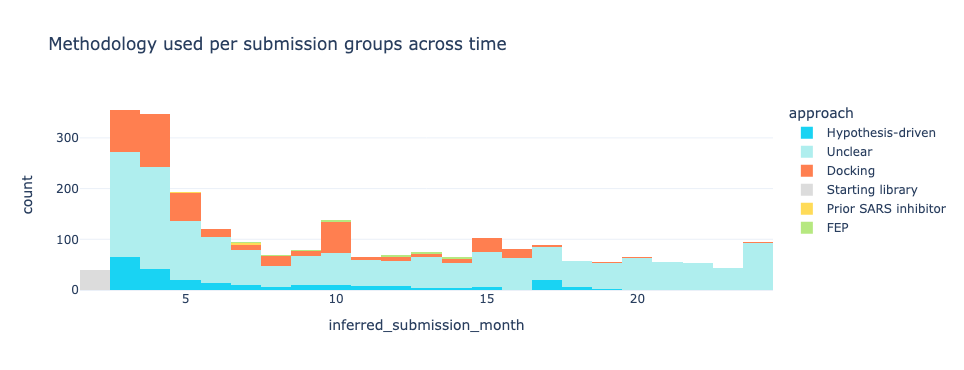

In [28]:
import plotly.express as px

fig = px.histogram(moonshot.drop_duplicates('CID_group'), 
                     'inferred_submission_month', 
                     color='approach',
                     color_discrete_map = {'Docking': '#ff7f50', 'Hypothesis-drivenL':'#30d5c8','Unclear': '#afeeee',
                                           'Prior SARS inhibitor':'#ffdb58','Starting library': 'gainsboro'},
                     title='Methodology used per submission groups across time',
                     template='plotly_white',
                    )
fig.write_image("images/methodology_time.svg", width=800, height=800, scale=2)
fig.write_image('images/methodology_time.jpg')
fig

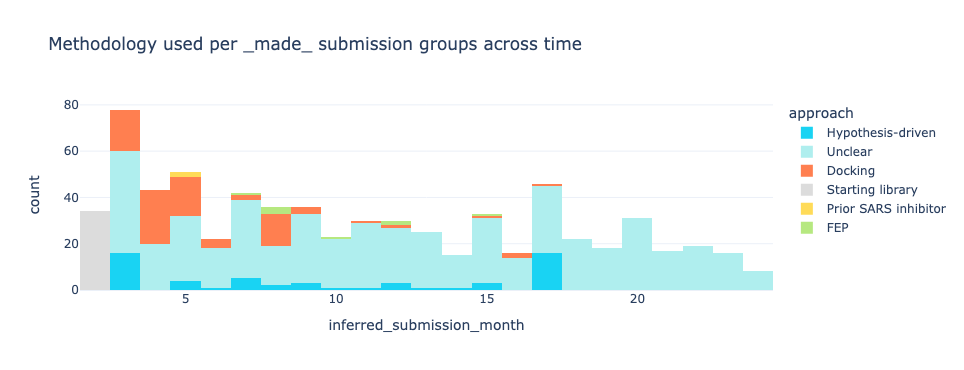

In [29]:
import plotly.express as px

fig = px.histogram(moonshot.loc[(moonshot.MADE)].drop_duplicates('CID_group'), 
                     'inferred_submission_month', 
                     color='approach',
                     color_discrete_map = {'Docking': '#ff7f50', 'Hypothesis-drivenL':'#30d5c8','Unclear': '#afeeee',
                                           'Prior SARS inhibitor':'#ffdb58','Starting library': 'gainsboro'},
                     title='Methodology used per _made_ submission groups across time',
                     template='plotly_white',
                    )
#fig.write_image("methodology_time.svg", width=800, height=800, scale=2)
fig

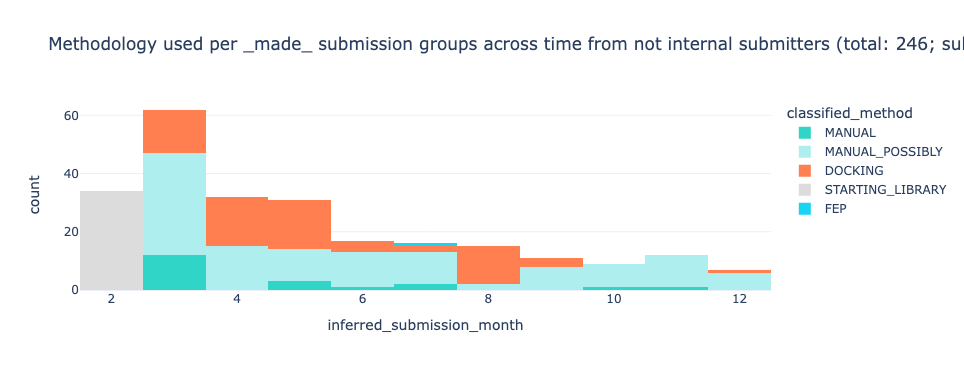

In [32]:
import plotly.express as px
from datetime import datetime

date_cutoff = datetime(2021, 1, 1)
subbed = moonshot.loc[(moonshot.MADE) & (~moonshot.internal) & (moonshot.inferred_submission_date < date_cutoff)].drop_duplicates('CID_group')

fig = px.histogram(subbed, 
                     'inferred_submission_month', 
                     color='classified_method',
                     color_discrete_map = {'DOCKING': '#ff7f50', 'MANUAL':'#30d5c8','MANUAL_POSSIBLY': '#afeeee',
                                           'PRIOR_SARS_INHIBITOR':'#ffdb58','STARTING_LIBRARY': 'gainsboro'},
                     title=f'Methodology used per _made_ submission groups across time from not internal submitters (total: {len(subbed)}; submitted prior to {date_cutoff.strftime("%d-%m-%Y")})',
                     template='plotly_white',
                    )
#fig.write_image("methodology_time.svg", width=800, height=800, scale=2)
fig

In [37]:
moonshot['category'] = moonshot.internal.map({True: 'Core', False: 'External'})
moonshot['short'] = moonshot.description.str.slice(0,50)

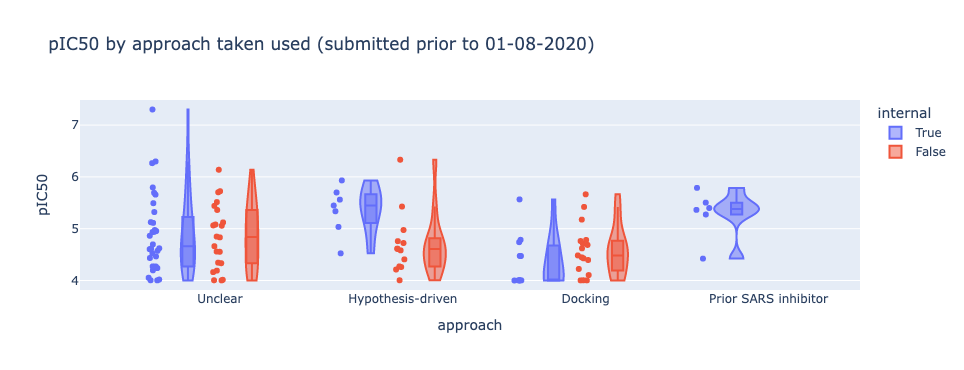

In [38]:
from datetime import datetime

date_cutoff = datetime(2020, 8, 1)

subbed = moonshot.loc[~moonshot.classified_method.isin(['STARTING_LIBRARY', 'UNKNOWN']) & \
                      (moonshot.submission_date < date_cutoff) & (moonshot.shipment_date < date_cutoff)
                     ]
fig = px.violin(subbed,
                title=f'pIC50 by approach taken used (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})',
                y='pIC50', x='approach',
               color='internal',
                hover_data=['CID (canonical)', 'clean_creator', 'shipment_date', 'site_name', 'short'],
               box=True,
               points='all')
fig.update_traces(spanmode = 'hard')
fig.write_image("methodology_vio.jpg")
fig

In [54]:
moonshot.lucky_creator.value_counts()

False    11681
True      2441
Name: lucky_creator, dtype: int64

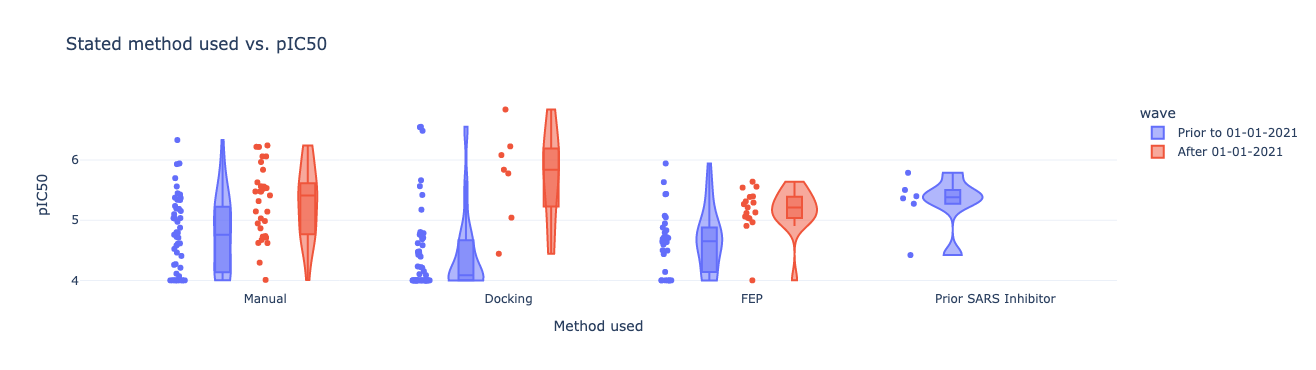

In [55]:
date_cutoff = datetime(2021, 1, 1)
moonshot['Method used'] = moonshot.classified_method.str.title().str.replace('_', ' ').str.replace('Sars', 'SARS').str.replace('Fep', 'FEP')
moonshot['wave'] =  ((moonshot.submission_date < date_cutoff) & (moonshot.shipment_date < date_cutoff)).map({True: f'Prior to {date_cutoff.strftime("%d-%m-%Y")}',
                                                                                                             False: f'After {date_cutoff.strftime("%d-%m-%Y")}'
                                                                                                             }
                                                                                                             )

subbed = moonshot.loc[~moonshot.classified_method.isin(['STARTING_LIBRARY', 'UNKNOWN', 'MANUAL_POSSIBLY'])]



fig = px.violin(subbed,
                template='plotly_white',
                title=f'Stated method used vs. pIC50',
                y='pIC50', x='Method used',
                #log_y=True,
               #color='lucky_creator',
               color='wave',
               category_orders={"Method used": ['Prior SARS Inhibitors', 'Manual', 'Docking', 'FEP'],
                               "wave": [f'Prior to {date_cutoff.strftime("%d-%m-%Y")}', f'After {date_cutoff.strftime("%d-%m-%Y")}'],
                               },
               box=True,
               points='all')
fig.update_traces(spanmode = 'hard')
fig.write_image("images/method_ic50.png", width=800, height=600, scale=2)
fig